In [233]:
# import block
import numpy as np
from astropy.io import fits
%matplotlib inline
from matplotlib import pyplot as plt
from astropy.visualization import hist
import ccdproc as ccdp
from matplotlib import rc
import os
import time

# for fitting models
from astropy.modeling import fitting
from astropy.modeling.models import Polynomial1D,Chebyshev1D,Legendre1D,Hermite1D

#from ccdproc import ImageFileCollection
#from astropy.modeling import fitting
#from astropy.stats import mad_std
from astropy.nddata import CCDData
#from scipy import stats
#from astropy import units as u
from datetime import datetime

phot_tutorial_dir = '/Users/polinapetrov/Documents/Vanderbilt/F21/Observational-Methods/phot_tutorial/notebooks'
plt.style.use(phot_tutorial_dir+'/guide.mplstyle')
rc('font', size=12)
rc('axes', grid=True)

In [4]:
data_dir = '/Users/polinapetrov/Documents/Vanderbilt/F21/Observational-Methods/Imaging/'
reduced_dir = '/Users/polinapetrov/Documents/Vanderbilt/F21/Observational-Methods/reduced/'

# Q5

Examine the all bias exposures (or overscan regions throughout the night) and quantify how much the bias level changes throughout the night. Compare the mean level of the biases to the mean levels of the overscan regions from other files throughout the night. How much variation do you find? Make an argument for whether it would be a good or bad idea to combine all of the biases to make a master bias and subtract that from all the images versus using the overscan region of each image as an estimate of the bias level.

In [155]:
#opening bias frames
imgs = ccdp.ImageFileCollection(reduced_dir,glob_include='a*.fits')
bias_files = imgs.files_filtered(imagetyp='bias',include_path=True)
biases = [CCDData.read(file,unit='adu') for file in bias_files]

Maximum change in counts: 0.30841619318186986


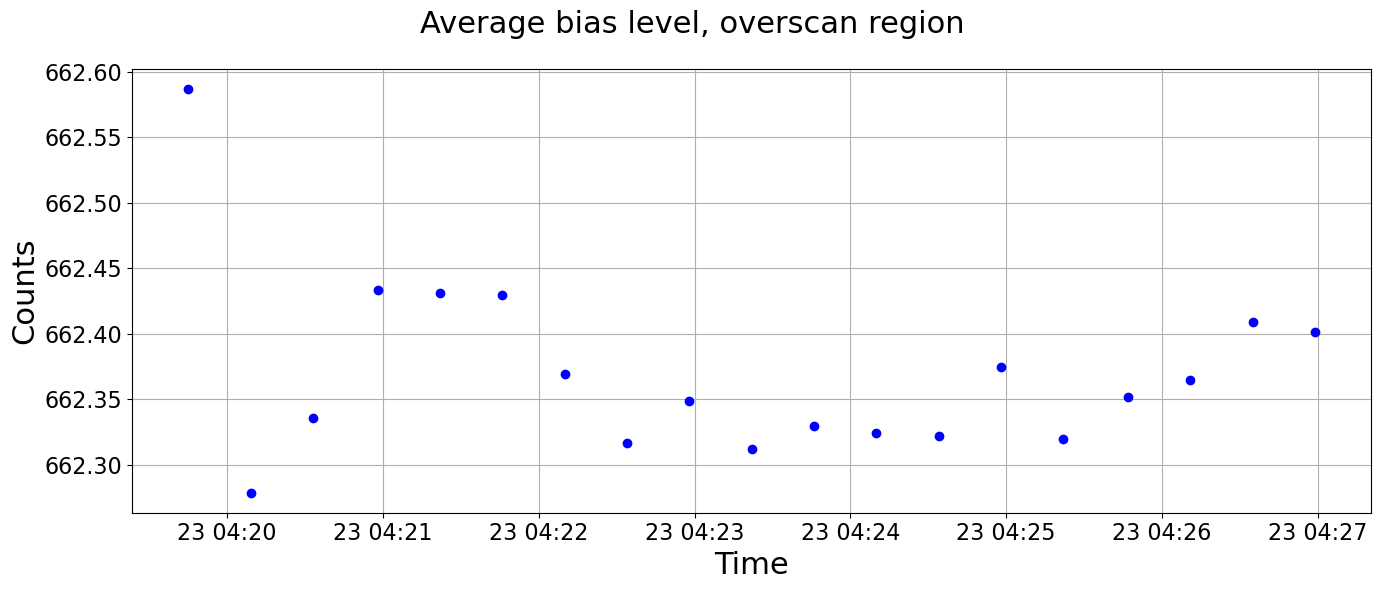

In [32]:
#specifying row and column ranges for overscan region
lo1 = 0 #rows
hi1 = 2048
lo2 = 2101 #columns
hi2 = 2200

#calculating mean bias values in the overscan region
overscan_mns = [np.mean((b.data)[lo1:hi1,lo2:hi2]) for b in biases]
print('Maximum change in counts:', max(overscan_mns)-min(overscan_mns))

#observing times
times = imgs.filter(imagetyp='bias').summary['date-obs'].data.data 
flat_times = [datetime.strptime(time,'%Y-%m-%dT%H:%M:%S.%f') for time in times]

#plotting mean overscan over time
fig, ax = plt.subplots(figsize=(14,6))
ax.plot(flat_times,overscan_mns,'blue',marker='o',ls='')
ax.set_xlabel(r'Time',fontsize=22)
ax.set_ylabel(r'Counts',fontsize=22)
fig.suptitle('Average bias level, overscan region', fontsize=22)
fig.tight_layout()

Maximum change in counts: 17.8285984848485


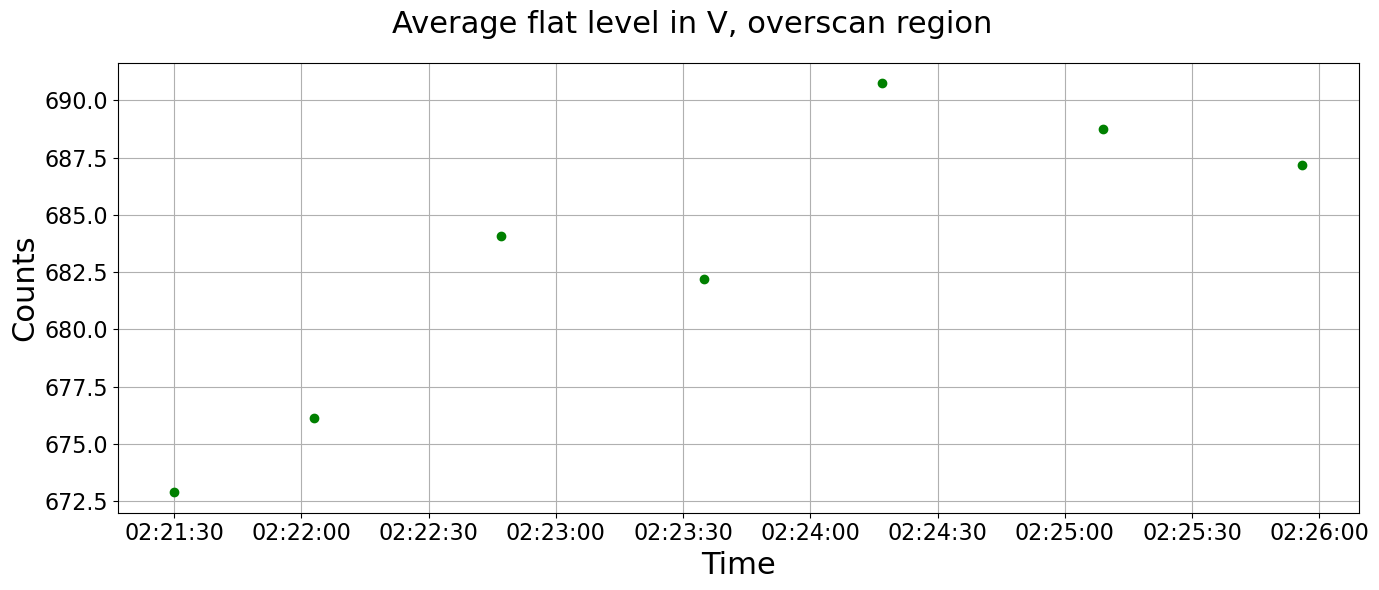

In [30]:
#Comparing to other files throughout the night: V-filter files
Vs = imgs.files_filtered(imagetyp='skyflat',filter='V',include_path=True)
V_files = [CCDData.read(file,unit='adu') for file in Vs]
V_overscan_mns = [np.mean((V_file.data)[lo1:hi1,lo2:hi2]) for V_file in V_files]
times = imgs.filter(imagetyp='skyflat',filter='V').summary['date-obs'].data.data 
V_times = [datetime.strptime(time,'%Y-%m-%dT%H:%M:%S.%f') for time in times]
print('Maximum change in counts:', max(V_overscan_mns)-min(V_overscan_mns))

#plotting mean overscan over time for V-band flats
fig, ax = plt.subplots(figsize=(14,6))
ax.plot(V_times,V_overscan_mns,'green',marker='o',ls='')
ax.set_xlabel(r'Time',fontsize=22)
ax.set_ylabel(r'Counts',fontsize=22)
fig.suptitle('Average flat level in V, overscan region', fontsize=22)
fig.tight_layout()

Maximum change in counts: 5.307212752525288


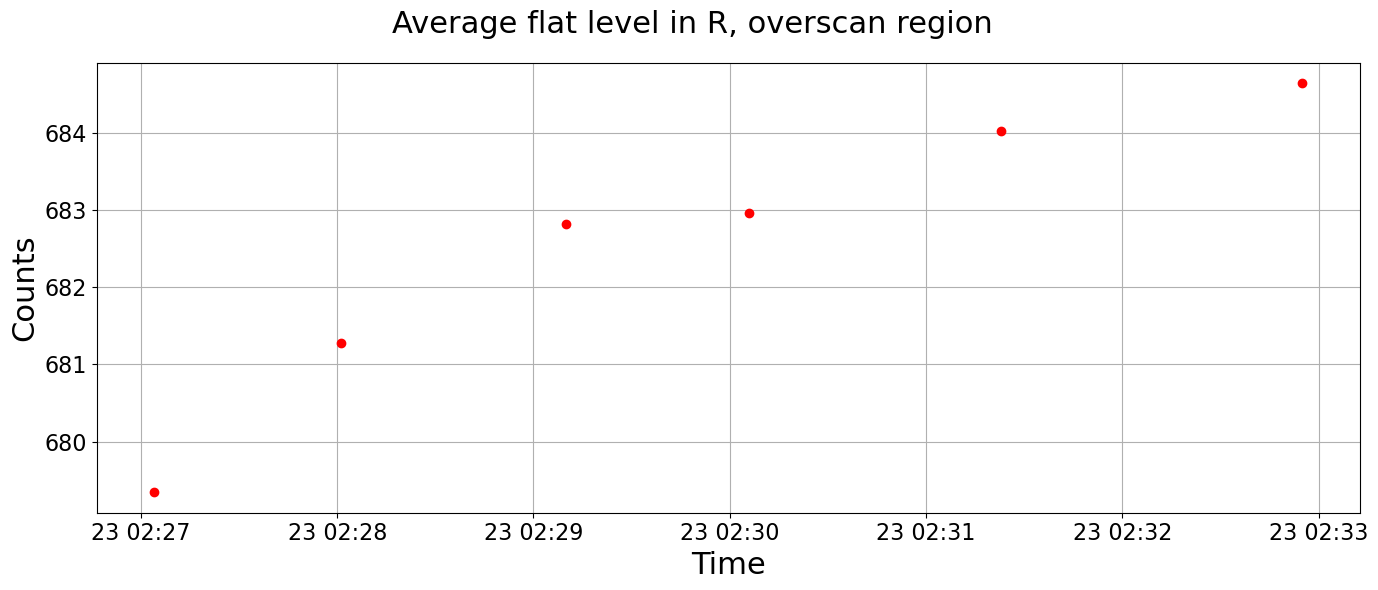

In [31]:
# get R-band filenames
nfiles = 6
nlow = 50

# read in the hdus, hdrs, data
# use list comprehension
R_files = [reduced_dir+'a'+str(i).zfill(3)+'.fits' for i in np.arange(nfiles)+nlow]
hdus = [fits.open(file) for file in R_files]
hdrs = [hdu[0].header for hdu in hdus]
Vs = [hdu[0].data for hdu in hdus]

# loop over the hdus or hdrs
    # add IMAGETYP, BIASSEC, TRIMSEC, FILTER
    # (I used 'skyflat' for my image type, if you use something else you'll need edit later code)
    # write out the hdu to the original fits file
for i in range(np.size(hdus)):
    hdrs[i]['BIASSEC'] = '[2102:2200,1:2048]'
    hdrs[i]['TRIMSEC'] = '[55:2101,1:2048]'
    hdrs[i]['FILTER'] = 'R'
    hdrs[i]['IMAGETYP'] = 'skyflat'
    hdus[i].writeto(R_files[i], overwrite=True)
    
#Comparing to other files throughout the night: R-filter files
Rs = imgs.files_filtered(imagetyp='skyflat',filter='R',include_path=True)
R_files = [CCDData.read(file,unit='adu') for file in Rs]
R_overscan_mns = [np.mean((R_file.data)[lo1:hi1,lo2:hi2]) for R_file in R_files]
times = imgs.filter(imagetyp='skyflat',filter='R').summary['date-obs'].data.data 
R_times = [datetime.strptime(time,'%Y-%m-%dT%H:%M:%S.%f') for time in times]
print('Maximum change in counts:', max(R_overscan_mns)-min(R_overscan_mns))

#plotting mean overscan over time for R-band flats
fig, ax = plt.subplots(figsize=(14,6))
ax.plot(R_times,R_overscan_mns,'red',marker='o',ls='')
ax.set_xlabel(r'Time',fontsize=22)
ax.set_ylabel(r'Counts',fontsize=22)
fig.suptitle('Average flat level in R, overscan region', fontsize=22)
fig.tight_layout()

Looking at the overscan regions in the bias exposures, the mean number of counts fluctuate by less than one count. When comparing to the overscan regions from other files, the mean number of counts fluctuate by a few counts for the R-band and by a few to several counts for the V-band, for example. The fluctuations in these science frames over time are sufficiently large that it would be a good idea to use the overscan region of each image as an estimate of the bias level. Solely using the overscan region of each image, though, does not take care of the bright vertical stripe in the trimsec portion of the bias frames. It would consequently be a good idea to also combine all of the biases to make a master bias and subtract that from all the images, as doing this will remove the vertical stripe.

# Q6
Using CCDPROC.SUBTRACT_OVERSCAN and CCDPROC.TRIM_IMAGE, fit and subtract the overscan region of each image and trim the image to remove the overscan region. In the overscan fitting, try out ’chebyshev’, ’legendre’, and ’hermite’, and ’polynomial’ of various orders for the fitting function. Qualitatively try to summarize the differences between the functions (you can also look up and summarize the properties of these types of polynomials, but this is not required). Also try orders 1 through about 8, and make an argument for how large an order is necessary to fit the overscan region.

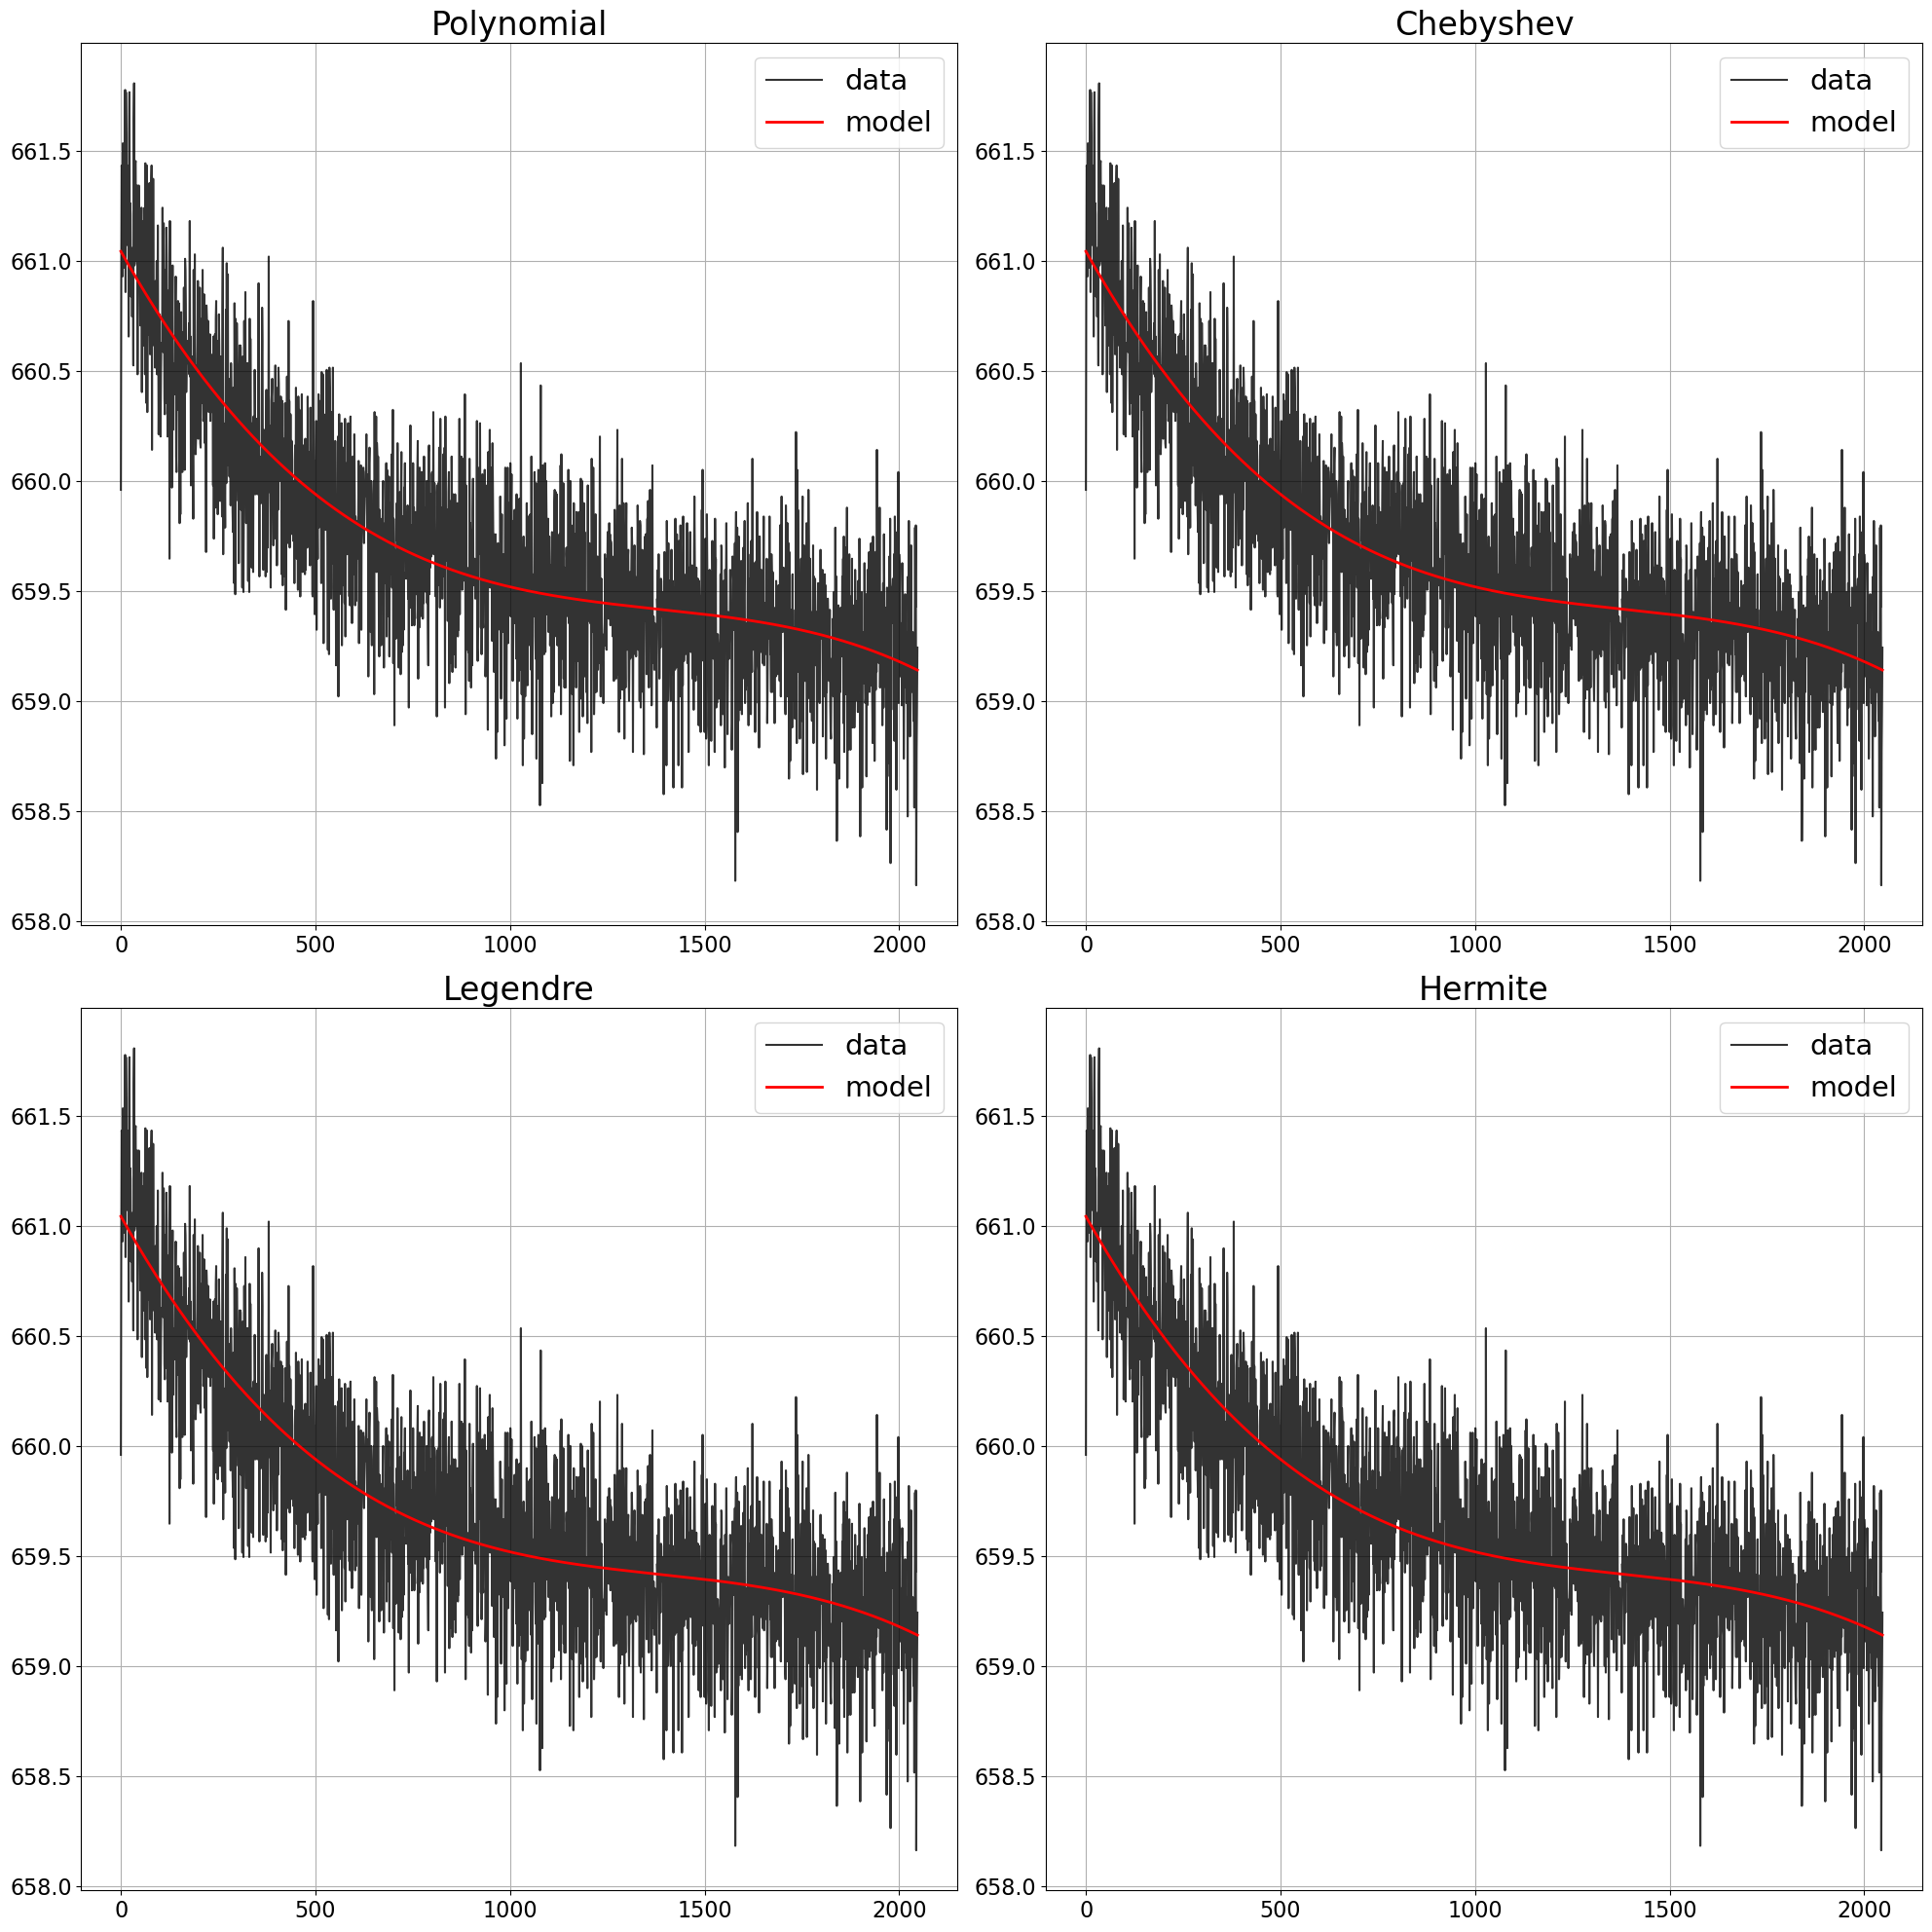

In [147]:
#examining fits for one science frame
file = fits.open(reduced_dir+'a130.fits')[0].data
mn = np.mean(file[lo1:hi1,lo2:hi2],axis=1)
rows_in_overscan = np.shape(mn)[0]
rows = np.arange(rows_in_overscan)

fitter = fitting.LinearLSQFitter()
degree = 3
models = [Polynomial1D(degree), Chebyshev1D(degree), Legendre1D(degree), Hermite1D(degree)]
xvals = rows
yvals = mn
wgts  = np.ones_like(mn)
best_fits = [fitter(model, xvals, yvals, weights=wgts) for model in models]
Bfits = [fit(xvals) for fit in best_fits]

fig, (ax1,ax2) = plt.subplots(2, 2, figsize=(20, 20))
ax1[0].set_title('Polynomial')
ax1[0].plot(xvals,yvals,ls='-',c='k',label='data',alpha=0.8)
ax1[0].plot(xvals,Bfits[0],ls='-',lw=2,c='r',alpha=1,label='model')
ax1[0].legend()
ax1[1].set_title('Chebyshev')
ax1[1].plot(xvals,yvals,ls='-',c='k',label='data',alpha=0.8)
ax1[1].plot(xvals,Bfits[1],ls='-',lw=2,c='r',alpha=1,label='model')
ax1[1].legend()
ax2[0].set_title('Legendre')
ax2[0].plot(xvals,yvals,ls='-',c='k',label='data',alpha=0.8)
ax2[0].plot(xvals,Bfits[2],ls='-',lw=2,c='r',alpha=1,label='model')
ax2[0].legend()
ax2[1].set_title('Hermite')
ax2[1].plot(xvals,yvals,ls='-',c='k',label='data',alpha=0.8)
ax2[1].plot(xvals,Bfits[3],ls='-',lw=2,c='r',alpha=1,label='model')
ax2[1].legend()
plt.tight_layout()

Qualitatively, these four fits look nearly identical. All are orthogonal polynomial sequences, with Chebyshev being orthogonal on the interval [-1,1] with the weight function 1/sqrt(1-x^2), Legendre also being orthogonal on the interval [-1,1], and Hermite being orthogonal on the interval (-infinity,infinity) with respect to the weight function exp(-x^2).

The fits shown here are using order 3. Using higher orders does not result in a significant difference in the fit and makes for a less efficient computation.

In [161]:
#adding biassec and trimsec to all frames
all_files = []
for i in range(1,247):
    if os.path.exists(reduced_dir+'a'+str(i).zfill(3)+'.fits'):
        all_files.append(reduced_dir+'a'+str(i).zfill(3)+'.fits')
hdus = [fits.open(file) for file in all_files]
hdrs = [hdu[0].header for hdu in hdus]
data = [hdu[0].data for hdu in hdus]

for i in range(np.size(hdus)):
    hdrs[i]['BIASSEC'] = '[2102:2200,1:2048]'
    hdrs[i]['TRIMSEC'] = '[55:2101,1:2048]'
    hdus[i].writeto(all_files[i], overwrite=True)

In [244]:
#model for fitting overscan region
model = Polynomial1D(3)

#subtracting overscan region of each image and trimming to remove overscan region
imgs = ccdp.ImageFileCollection(reduced_dir,glob_include='a*.fits',glob_exclude='*ot.fits')
for ccd, file_name in imgs.ccds(ccd_kwargs={'unit': 'adu'},return_fname=True):
    ccd_sav = ccd
    ccd = ccdp.subtract_overscan(ccd, fits_section=ccd.header['biassec'], median=False, model=model)
    ccd = ccdp.trim_image(ccd,fits_section=ccd.header['trimsec'])
    outfile = file_name.strip('.fits')+'ot.fits'
    ccd.write(reduced_dir+outfile, overwrite=True)

# Q7

Combine the bias frames into a master bias frame using CCDPROC.COMBINE. By visual inspection or using image statistics, decide whether it is appropriate to combine all your bias exposures to make 1 master bias, or whether you need to restrict the input frames because of variations among your bias frames. Are there trends in your sequence of bias frames? Does either the level, or the pattern of the bias change throughout the night? If so, by how much? How much noise would you be adding to your data if you decide to do a bias subtraction in addition to your overscan subtraction? Do the subtraction of your master bias from all other science frames if you can justify that it is warranted.

In [188]:
#creating master bias, excluding first frame
bias_restricted = bias_files[1:]
bias_mn_master = ccdp.combine(bias_restricted,method='average',unit='adu',sigma_clip=False)

See "Average bias level, overscan region" plot from Q5. While the average counts do not fluctuate by more than one count between frames (over time), the mean level in the first bias frame clearly stands out compared to the other frames (bias changes by about 0.3 counts). Therefore the first bias frame was excluded in the making of the master bias. Creating a master bias reduces the noise, so by doing a bias subtraction as well as an overscan subtraction, noise would be reduced rather than added. Subtraction of the master bias from science frames is warranted as it will effectively remove the bright vertical stripe in the frames.

# Q8

Now examine the ‘dark’ images quantitatively and estimate the range of dark current (electrons per pixel per second) you see in the darks. WIRO Prime’s gain is 2.5 e−/ADU. Use Python to inspect the header and see the exposure time in each of the darks. Pixel values will vary! Be careful to avoid being fooled by cosmic rays, which will appear as large bright spots usually spread over a few pixels, whereas high dark current is usually isolated to just individual pixels.

In [200]:
#opening dark frames
nfiles = 15
nlow = 1
dark_files = [reduced_dir+'d'+str(i).zfill(3)+'.fits' for i in np.arange(nfiles)+nlow]
hdus = [fits.open(file) for file in dark_files]
hdrs = [hdu[0].header for hdu in hdus]
darks = [hdu[0].data for hdu in hdus]

In [201]:
#examining headers for exposure times
hdrs

[SIMPLE  =                    T / Fits standard                                  
 BITPIX  =                   16 / Bits per pixel                                 
 NAXIS   =                    2 / Number of axes                                 
 NAXIS1  =                 2200 / Axis length                                    
 NAXIS2  =                 2048 / Axis length                                    
 EXTEND  =                    F / File may contain extensions                    
 BSCALE  =           1.000000E0 / REAL = TAPE*BSCALE + BZERO                     
 BZERO   =           3.276800E4 /                                                
 ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 2003' / FITS file originator        
 DATE    = '2007-10-10T18:18:58' / Date FITS file was generated                  
 IRAF-TLM= '12:18:57 (10/10/2007)' / Time of last modification                   
 DATAMIN =           6.140000E2 / Minimum data value                             
 DATAMAX =      

In [241]:
#examining electrons per pixel per second for one dark frame
#printing mean of electrons per pixel per second over entire frame
dark1 = darks[0]
exptime1 = hdrs[0]['EXPTIME']
dark1_per_sec = []
dark1_per_sec_vals = []
for row in range(0,len(dark1)):
    row_per_sec = []
    for col in range(0,len(dark1[0])):
        per_sec_val = dark1[row][col]/exptime1
        row_per_sec.append(per_sec_val)
        dark1_per_sec_vals.append(per_sec_val)
    dark1_per_sec.append(row_per_sec)
print(np.mean(dark1_per_sec_vals))

330.3254913884943


The single dark frame above has an exposure time of 2s, and the dark current is roughly 330 electrons per pixel per second. Repeating this for a dark frame with an exposure time of 5s and 300s, the dark current (in electrons per pixel per second) is about 130 and 2, respectively. These values are illustrated in the next plot.

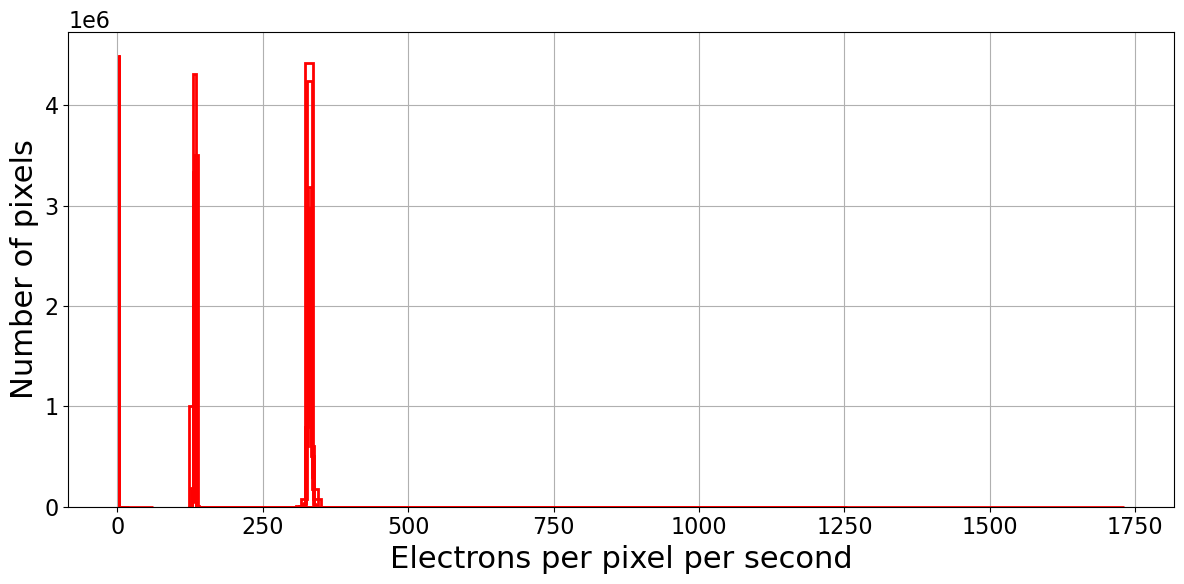

In [245]:
#plotting histogram of electrons per pixel per second for all 15 dark frames
fig, ax = plt.subplots(figsize=(12,6))
for frame in range(0,len(darks)):
    dark_F = darks[frame]
    exptime = hdrs[frame]['EXPTIME']
    #dark_per_sec = []
    dark_per_sec_vals = []
    for row in range(0,len(dark_F)):
        #row_per_sec = []
        for col in range(0,len(dark1[frame])):
            per_sec_val = dark_F[row][col]/exptime
            #row_per_sec.append(per_sec_val)
            dark_per_sec_vals.append(per_sec_val)
        #dark1_per_sec.append(row_per_sec)
    plt.hist(dark_per_sec_vals, bins=100, color='red', histtype='step', lw=2)
ax.set_xlabel(r'Electrons per pixel per second',fontsize=22)
ax.set_ylabel(r'Number of pixels',fontsize=22)
fig.tight_layout()

# Q9

Use CCDPROC.COMBINE to combine darks together to make a master dark. You will need to play with different combination parameters to see which one does the best job of eliminating cosmic rays. At a minimum, do
- A straight average of all dark frames.
- A straight median of all dark frames.
- An average where outlier pixels are rejected if they are more than 3σ away from the mean.
- A median where outlier pixels are rejected if they are more than 3σ away from the mean.

Use the resulting RMS in the master image as an indicator of which combination procedure is best. Compare your master dark to your master bias to estimate the significance of the highest dark count pixels. How many times larger is the typical dark current than the noise (σ) in the master image?

In [246]:
#sigma_clip default is 3σ
dark_mn_ccdp = ccdp.combine(dark_files,method='average',unit='adu',sigma_clip=False) #straight average
dark_med_ccdp = ccdp.combine(dark_files,method='median',unit='adu',sigma_clip=False) #straight median
dark_mn_3sig_ccdp = ccdp.combine(dark_files,method='average',unit='adu',sigma_clip=True) #straight average
dark_med_3sig_ccdp = ccdp.combine(dark_files,method='median',unit='adu',sigma_clip=True) #straight median

In [251]:
mn_rms = np.std(dark_mn_ccdp)
med_rms = np.std(dark_med_ccdp)
mn_3sig_rms = np.std(dark_mn_3sig_ccdp)
med_3sig_rms = np.std(dark_med_3sig_ccdp)

print('Straight average:',mn_rms)
print('Straight median:',med_rms)
print('Average with sigma clipping:',mn_3sig_rms)
print('Median with sigma clipping:',med_3sig_rms)

Straight average: 3.076591342639415
Straight median: 2.918116967637125
Average with sigma clipping: 2.8313169722072056
Median with sigma clipping: 2.9180825137797073


Looks like average with 3σ clipping is the best combination procedure.

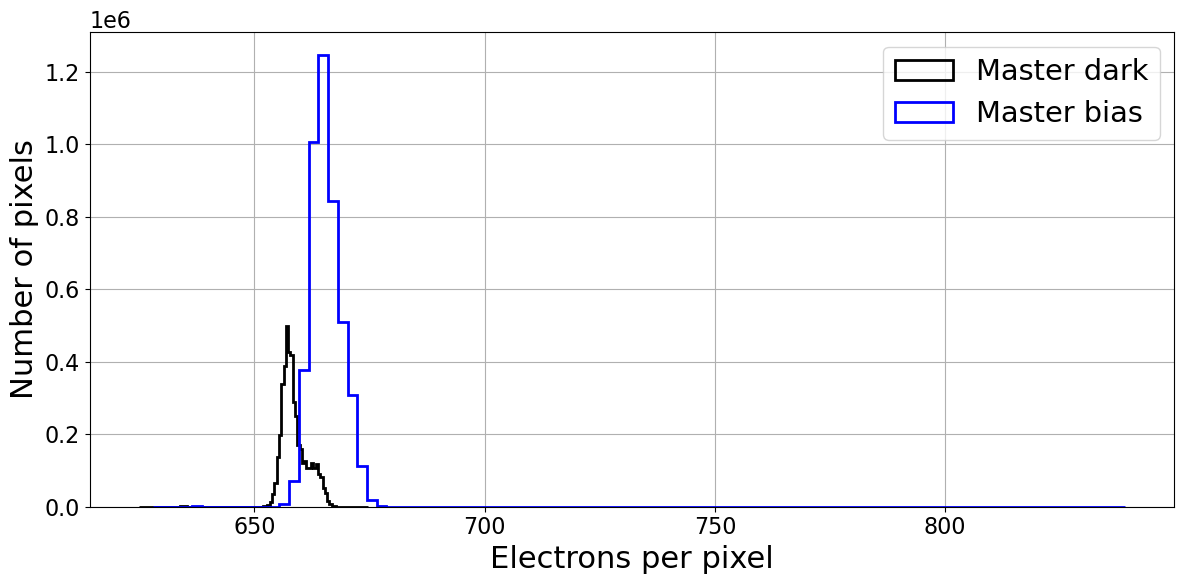

In [264]:
dark_master_vals = []
for row in range(0,len(dark_mn_3sig_ccdp.data)):
    for col in range(0,len(dark_mn_3sig_ccdp.data[0])):
        val = dark_mn_3sig_ccdp.data[row][col]
        dark_master_vals.append(val)
bias_master_vals = []
for row in range(0,len(bias_mn_master.data)):
    for col in range(0,len(bias_mn_master.data[0])):
        val = bias_mn_master.data[row][col]
        bias_master_vals.append(val)



fig, ax = plt.subplots(figsize=(12,6))
plt.hist(dark_master_vals, bins=100, color='black', histtype='step', lw=2, label='Master dark')
plt.hist(bias_master_vals, bins=100, color='blue', histtype='step', lw=2, label='Master bias')
ax.set_xlabel(r'Electrons per pixel',fontsize=22)
ax.set_ylabel(r'Number of pixels',fontsize=22)
plt.legend()
fig.tight_layout()

Peak of master dark is roughly 0.5e6 = 500000 pixels at ~655 electrons per pix. Peak of master bias is roughly 1.25e6 = 1250000 pixels at ~670 electrons per pix. Some dark frame pixels can be seen to reach as high as ~670 electrons per pix, where the peak of the master bias is.

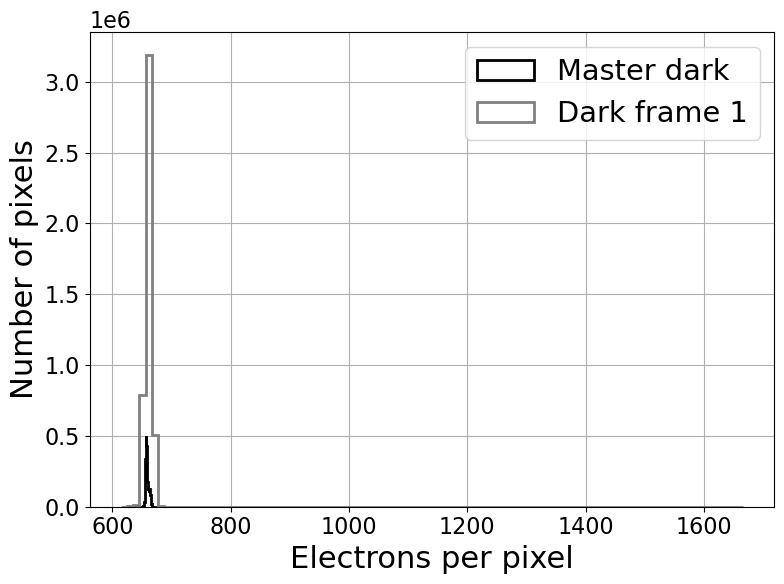

In [267]:
fig, ax = plt.subplots(figsize=(8,6))
plt.hist(dark_master_vals, bins=100, color='black', histtype='step', lw=2, label='Master dark')
plt.hist([dark_val*exptime1 for dark_val in dark1_per_sec_vals], bins=100, color='gray', histtype='step', lw=2, label='Dark frame 1')
ax.set_xlabel(r'Electrons per pixel',fontsize=22)
ax.set_ylabel(r'Number of pixels',fontsize=22)
plt.legend()
fig.tight_layout()

The example dark current frame shown in gray peaks at ~3.2e6 = 3200000 pixels. This is ~6.4 times larger than the noise in the master image.